In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import *
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
df = pd.read_csv('../finaldata.csv', sep=',').set_index('Date')


In [4]:
b=df

In [5]:
b

,T2M,QV2M,PRECTOTCORR,WS10M,Hour_sin,Hour_cos,Day_sin,Day_cos
Date,,,,,,,,
2005-01-02 00:00:00,12.12,5.68,0.0,1.14,0.000000,1.000000,0.034422,0.999407
2005-01-02 01:00:00,11.80,5.62,0.0,1.26,0.258819,0.965926,0.034422,0.999407
2005-01-02 02:00:00,11.32,5.55,0.0,1.40,0.500000,0.866025,0.034422,0.999407
2005-01-02 03:00:00,11.03,5.43,0.0,1.53,0.707107,0.707107,0.034422,0.999407
2005-01-02 04:00:00,10.92,5.31,0.0,1.65,0.866025,0.500000,0.034422,0.999407
...,...,...,...,...,...,...,...,...
2022-11-15 01:00:00,12.45,7.45,0.0,0.76,0.258819,0.965926,0.255353,0.966848
2022-11-15 02:00:00,12.25,7.32,0.0,0.96,0.500000,0.866025,0.255353,0.966848
2022-11-15 03:00:00,11.83,7.20,0.0,1.06,0.707107,0.707107,0.255353,0.966848


In [6]:
b.tail()

,T2M,QV2M,PRECTOTCORR,WS10M,Hour_sin,Hour_cos,Day_sin,Day_cos
Date,,,,,,,,
2022-11-15 01:00:00,12.45,7.45,0.0,0.76,0.258819,0.965926,0.255353,0.966848
2022-11-15 02:00:00,12.25,7.32,0.0,0.96,0.500000,0.866025,0.255353,0.966848
2022-11-15 03:00:00,11.83,7.20,0.0,1.06,0.707107,0.707107,0.255353,0.966848
2022-11-15 04:00:00,11.60,7.08,0.0,1.13,0.866025,0.500000,0.255353,0.966848
2022-11-15 05:00:00,11.69,6.96,0.0,1.22,0.965926,0.258819,0.255353,0.966848


In [7]:
n_steps_out=5
n_steps_in= 24
n_features = 8

In [8]:
# split a multivariate sequence into samples
def split_sequences(df, n_steps_in, n_steps_out):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)):
 # find the end of this pattern
         end_ix = i + n_steps_in
         out_end_ix = end_ix + n_steps_out
 # check if we are beyond the dataset
         if out_end_ix > len(df_as_np):
             break
 # gather input and output parts of the pattern
         seq_x, seq_y = df_as_np[i:end_ix, :], df_as_np[end_ix:out_end_ix, :2]
         X.append(seq_x)
         y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
X, y = split_sequences(b, n_steps_out=5,
n_steps_in= 24)
X.shape, y.shape

((156602, 24, 8), (156602, 5, 2))

In [10]:
X_train, y_train = X[:135000], y[:135000]
X_val, y_val = X[135000:150000], y[135000:150000]
X_test, y_test = X[150000:], y[150000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((135000, 24, 8),
 (135000, 5, 2),
 (15000, 24, 8),
 (15000, 5, 2),
 (6602, 24, 8),
 (6602, 5, 2))

In [82]:

def plot_predictions(model, X, y):
    
    
    predictions = model.predict(X) 
    
    T2M_preds, QV2M_preds  = (predictions[:,:, 0]),(predictions[:,:, 1])
    T2M_actuals, QV2M_actuals =y[:,:, 0],y[:,:, 1]
    
    T2M_preds = T2M_preds.reshape(5)
    QV2M_preds = QV2M_preds.reshape(5)
    
    
    T2M_actuals, QV2M_actuals =y[:,:, 0],y[:,:, 1]
    
    T2M_actuals = T2M_actuals.reshape(5)
    QV2M_actuals = QV2M_actuals.reshape(5)
    
    
    df = pd.DataFrame(data={'Temperature Predictions': T2M_preds,
                        'Temperature Actuals':T2M_actuals,
                            
                          'Humidity Predictions': QV2M_preds,
                          'Humidity Actuals': QV2M_actuals,
                          })
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# plot temperature data on the first subplot
    ax1.plot(df['Temperature Predictions'], label='Temperature Predictions', color='blue', linewidth=2)
    ax1.plot(df['Temperature Actuals'], label='Temperature Actuals', color='orange', linewidth=2)
    ax1.set_xticks(range(len(df.index)))
    ax1.set_ylim([4, 10])
    ax1.set_xticklabels(df.index)
    ax1.legend(fontsize=14)
   
    

# plot humidity data on the second subplot
    ax2.plot(df['Humidity Predictions'], label='Humidity Predictions', color='green', linewidth=2)
    ax2.plot(df['Humidity Actuals'], label='Humidity Actuals', color='red', linewidth=2)
    ax2.set_xticks(range(len(df.index)))
    ax2.set_ylim([2, 8])
    ax2.set_xticklabels(df.index)
    ax2.legend(fontsize = 14)
    ax2.tick_params(axis='x', labelsize=14)
    ax2.tick_params(axis='y', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    
    ax1.set_title('Temperature Predictions vs. Actuals', fontsize=18)
    ax2.set_title('Humidity Predictions vs. Actuals', fontsize=18)
    
    
    ax1.set_xlabel('Hours', fontsize= 18)
    ax1.set_ylabel('Degrees', fontsize = 18)
    ax2.set_xlabel('Hours', fontsize= 18)
    ax2.set_ylabel('g/kg', fontsize= 18)
    
    for col in ['Temperature', 'Humidity']:
        for metric in ['MAE', 'MSE', 'RMSE', 'MAPE']:
            preds_col = col + ' Predictions'
            actuals_col = col + ' Actuals'
            preds = df[preds_col]
            actuals = df[actuals_col]
            if metric == 'MAE':
                result = mean_absolute_error(actuals, preds)
            elif metric == 'MSE':
                result = mean_squared_error(actuals, preds)
            elif metric == 'RMSE':
                result = np.sqrt(mean_squared_error(actuals, preds))
            elif metric == 'MAPE':
                result = np.mean(np.abs((actuals - preds) / actuals)) * 100
            print(f'{col} {metric}: {result:.2f}')

# set common labels for both subplots
    fig.text(0.5, 0.04, 'Row Number', ha='center')
    fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

# adjust spacing between subplots
    plt.subplots_adjust(wspace=0.4)

# show the plot
    plt.show()
    
    return df

In [ ]:
scale_factor = 0.1
ax1_y_new_lower = (1 - scale_factor) * ax1_y_old_lower
ax1_y_new_upper = (1 + scale_factor) * ax1_y_old_upper


In [14]:
lstm_model = tf.keras.models.load_model('model_lstm')
gru_model = tf.keras.models.load_model('model_gru')

1/1 [==============================] - 0s 30ms/step
Temperature MAE: 0.16
Temperature MSE: 0.03
Temperature RMSE: 0.18
Temperature MAPE: 2.33
Humidity MAE: 0.16
Humidity MSE: 0.04
Humidity RMSE: 0.19
Humidity MAPE: 3.00


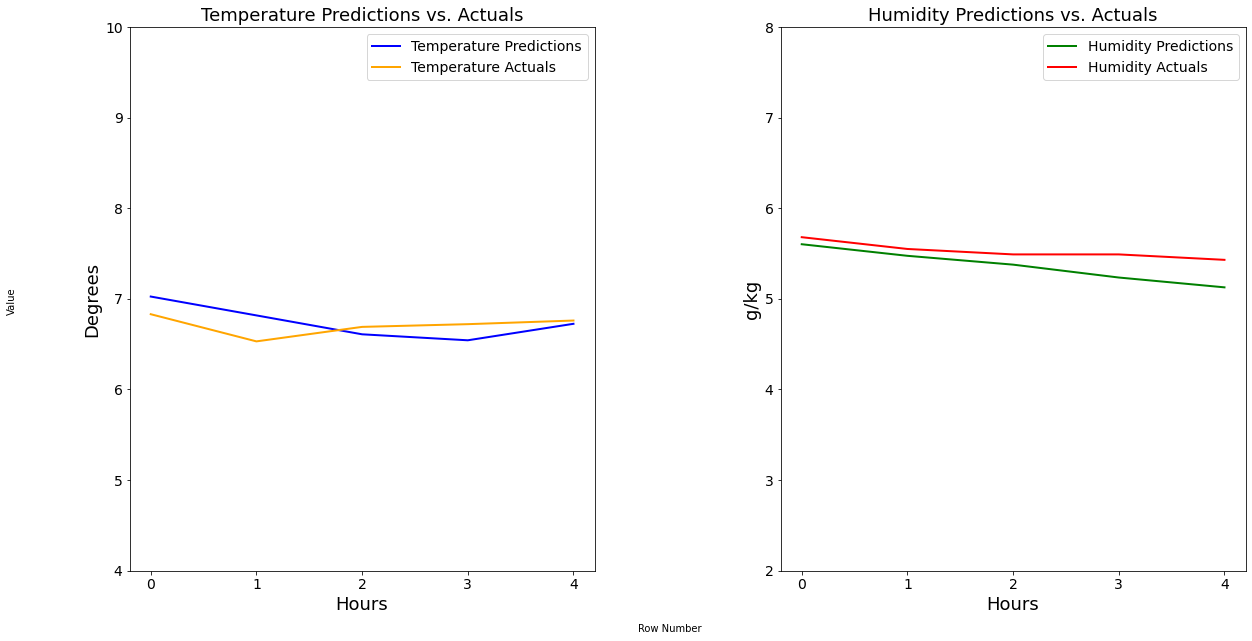

In [83]:
lstm_out = plot_predictions(lstm_model, X = X_test[2:3], y = y_test[2:3])

In [84]:
lstm_out

,Temperature Predictions,Temperature Actuals,Humidity Predictions,Humidity Actuals
0,7.024812,6.83,5.602304,5.68
1,6.816737,6.53,5.474475,5.55
2,6.608126,6.69,5.377059,5.49
3,6.542044,6.72,5.234852,5.49
4,6.724068,6.76,5.126429,5.43


1/1 [==============================] - 0s 24ms/step
Temperature MAE: 0.19
Temperature MSE: 0.04
Temperature RMSE: 0.20
Temperature MAPE: 2.87
Humidity MAE: 0.20
Humidity MSE: 0.05
Humidity RMSE: 0.22
Humidity MAPE: 3.59


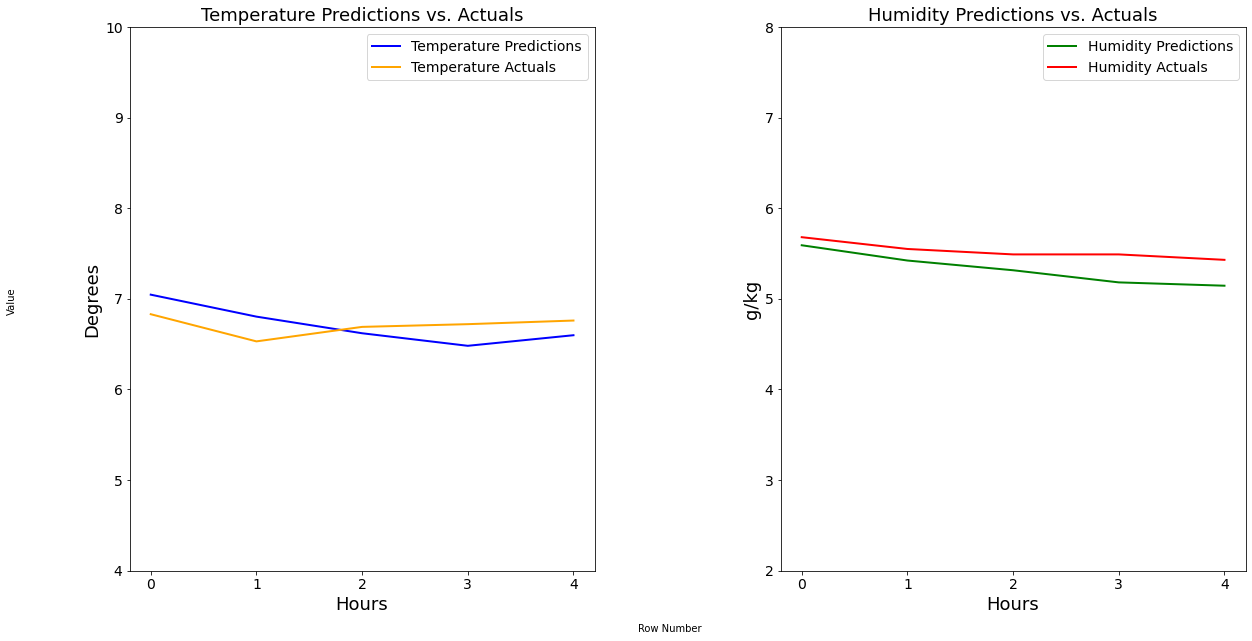

In [85]:
gru_out = plot_predictions(gru_model, X = X_test[2:3], y = y_test[2:3])

In [18]:
gru_out

,Temperature Predictions,Temperature Actuals,Humidity Predictions,Humidity Actuals
0,7.045759,6.83,5.590951,5.68
1,6.803267,6.53,5.422416,5.55
2,6.619730,6.69,5.315095,5.49
3,6.481194,6.72,5.181169,5.49
4,6.597978,6.76,5.144498,5.43
